In [1]:
%reload_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import numpy as np
from io import StringIO
import altair as alt
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('nbc_analysis.log', sep='|', header=0, names=['log_ts','level','module','msg'])
RAW = df

In [10]:
df.module.value_counts()

nbc_analysis.generate_po1_profiles.main            11769
nbc_analysis.partition.partition_by_viewer.main     7693
nbc_analysis.utils.aws_utils                         961
nbc_analysis.batch.upload_batches.main               838
nbc_analysis.batch.extract_events.main               838
nbc_analysis.utils.io_utils.aws_io                   814
nbc_analysis.utils.io_utils.csv_io                    89
nbc_analysis.runs.run_batches                         52
nbc_analysis.batch.size_batches.main                  38
nbc_analysis.batch.extract_file_lists.main            26
nbc_analysis.utils.config_utils                       13
nbc_analysis.runs.init_run.main                        6
Name: module, dtype: int64

In [11]:
start_week_mask = df.msg.str.startswith('start week')
end_week_mask = df.msg.str.startswith('end week')
write_partition_mask = (df.module == 'nbc_analysis.batch.extract_events.main') & (df.msg.str.startswith('wrote partition'))

In [12]:
df[write_partition_mask]

,log_ts,level,module,msg
36,"2019-10-11 19:15:00,354",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
38,"2019-10-11 19:15:58,513",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
40,"2019-10-11 19:16:54,131",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
42,"2019-10-11 19:17:51,622",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
44,"2019-10-11 19:19:15,830",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
...,...,...,...,...
2619,"2019-10-12 16:35:10,042",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
2621,"2019-10-12 16:36:46,431",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
2623,"2019-10-12 16:38:14,892",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...
2625,"2019-10-12 16:39:39,742",INFO,nbc_analysis.batch.extract_events.main,wrote partition /home/ec2-user/DATA/NBC/runs/r...


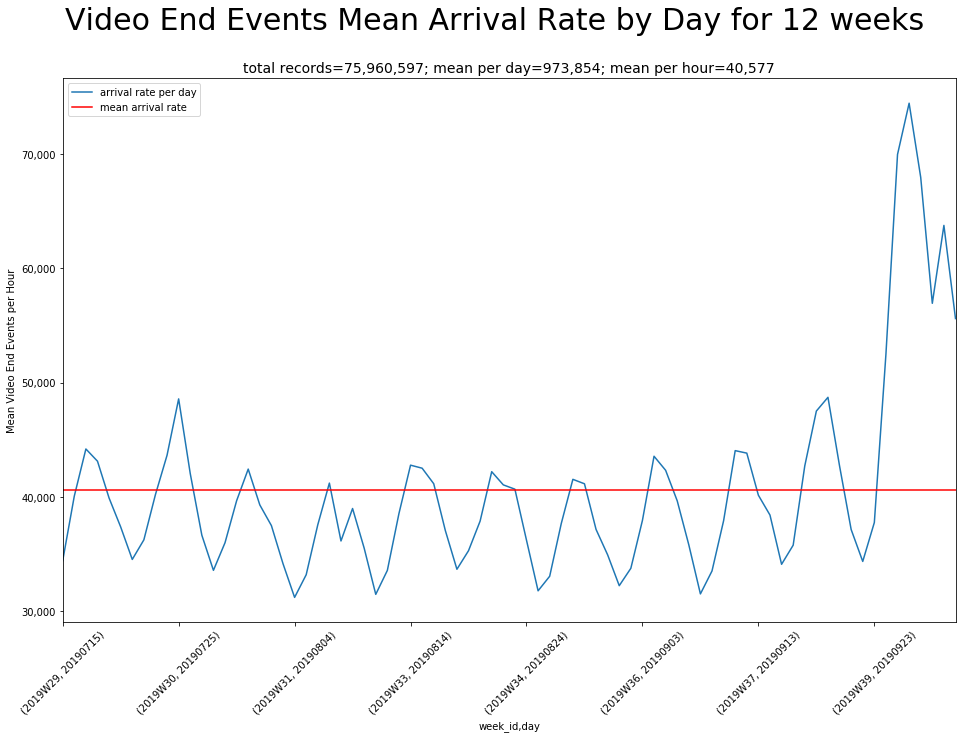

In [13]:
df = RAW[write_partition_mask].copy()
items = df.msg.str.split(',')
record_cnt = pd.Series(items.map(lambda x: x[1].split('=')[1]), name='record_cnt').astype(np.int)
batch_id = pd.Series(items.map(lambda x: x[0].split('/')[-1].split('.')[0]), name='batch_id')
day = pd.Series(batch_id.map(lambda x: x.split('_')[1]), name='day')
day_seq = pd.Series(batch_id.map(lambda x: x.split('_')[2]), name='day_seq')
week_id = pd.Series(items.map( lambda x: x[0].split('/')[7]), name= 'week_id')

df = pd.DataFrame([week_id, day, batch_id, record_cnt]).T
df['records_per_day'] = 24
df = df.sort_values('day')
record_cnt = df.groupby(['week_id', 'day']).record_cnt.sum()[:-1]
records_per_day = record_cnt.mean().round()

total_records = record_cnt.sum()

subtitle2 = "mean per day={:,.0f}".format(records_per_day)
subtitle3 = "mean per hour={:,.0f}".format(records_per_day/ 24)
subtitle1 = "total records={:,.0f}".format(total_records)

fig = plt.figure(figsize=[16, 10])
fig.suptitle(f'Video End Events Mean Arrival Rate by Day for 12 weeks', fontsize=30)

ax = record_cnt.div(24).plot(rot=45, label='arrival rate per day')
ax.set_title(f'{subtitle1}; {subtitle2}; {subtitle3}', fontsize=14);
ax.set_ylabel('Mean Video End Events per Hour')
ax.set_yticklabels(['{:,d}'.format(int(y)) for y in ax.get_yticks()]);
ax.axhline(y= records_per_day/24, color='r', label='mean arrival rate')
ax.legend();

In [14]:
event_type = pd.read_csv(StringIO("""event_type;sample_cnt
custom_event;240261 
user_attribute_change;82989 
application_state_transition;28167 
session_start;6917 
session_end;6285 
push_message;3969 
push_registration;692 
user_identity_change;73 
:none;4 
"""), sep=';')
event_type['event_type_pct'] = event_type.sample_cnt / event_type.sample_cnt.sum()
event_type

,event_type,sample_cnt,event_type_pct
0,custom_event,240261,0.650484
1,user_attribute_change,82989,0.224685
2,application_state_transition,28167,0.076260
3,session_start,6917,0.018727
4,session_end,6285,0.017016
5,push_message,3969,0.010746
6,push_registration,692,0.001874
7,user_identity_change,73,0.000198
8,:none,4,0.000011


In [15]:
event_name = pd.read_csv(StringIO("""event_name;sample_cnt
Ad End;15165 
Ad Start;15016 
Page Load;8652 
Ad Pod Start;3804 
Ad Pod End;3525 
Video Preview;3010 
Content Click;2547 
Launch;1620 
Video Start;1539 
Video End;1473 
End Card;528 
Error;372 
Click Action;252 
Linear Program End;207 
Linear End;200 
Linear Program Start;176 
Linear Start;168 
Search Result;138 
Authentication Success;53
MVPD Page Abandoned;42 
Conversion;25 
NBC Authentication Success;24 
Error CPC;11 
Registration Success;9 
Error IDM;3 
NBC Sign Out;3 
Item Favorited;2"""), sep=';')
event_name['event_type'] = 'custom_event'
event_name['event_pct'] = event_name.sample_cnt / event_name.sample_cnt.sum()
event_name

,event_name,sample_cnt,event_type,event_pct
0,Ad End,15165,custom_event,0.258947
1,Ad Start,15016,custom_event,0.256403
2,Page Load,8652,custom_event,0.147736
3,Ad Pod Start,3804,custom_event,0.064955
4,Ad Pod End,3525,custom_event,0.060191
5,Video Preview,3010,custom_event,0.051397
6,Content Click,2547,custom_event,0.043491
7,Launch,1620,custom_event,0.027662
8,Video Start,1539,custom_event,0.026279
9,Video End,1473,custom_event,0.025152


In [16]:
ve_ratio = event_name[event_name.event_name == 'Video End'].iloc[0].event_pct
cust_events_per_day = records_per_day/ ve_ratio
cust_events_per_day
event_name['est_events_per_day'] = (event_name.event_pct * cust_events_per_day).round().astype(np.int)

print(event_name.est_events_per_day.sum())
#event_name

38718794


In [17]:
total_custom_events = event_name.est_events_per_day.sum()
total_custom_events

38718794

In [18]:
custom_event_ratio = event_type.query('event_type=="custom_event"').event_type_pct[0]
total_event_types = total_custom_events / custom_event_ratio
total_event_types

59523008.709103845

In [19]:
event_type['est_events_per_day'] = (event_type.event_type_pct * total_event_types).round().astype(np.int)
event_type['event_name'] = event_type.event_type
#event_type

In [20]:
cols = ['event_type', 'event_name', 'est_events_per_day']

estimates = pd.concat( [event_type.iloc[1:][cols],event_name[cols]]).sort_values(['est_events_per_day'], ascending=False)
estimates['est_events_per_hour'] = (estimates.est_events_per_day / 24).round(1)
estimates['est_events_per_sec'] =estimates['est_events_per_sec'] = (estimates['est_events_per_hour'] / (60*60)).round(1)
estimates['in_scope'] = estimates.event_name.isin({'Video End','Video Start', 'End Card','Ad End', 'Ad Start'})
estimates  = estimates.reset_index(drop=True)
estimates.index.name = 'idx'
estimates = estimates[estimates.in_scope].reset_index(drop=True).drop(columns=['event_type', 'in_scope'])
estimates

,event_name,est_events_per_day,est_events_per_hour,est_events_per_sec
0,Ad End,10026134,417755.6,116.0
1,Ad Start,9927625,413651.0,114.9
2,Video Start,1017489,42395.4,11.8
3,Video End,973854,40577.2,11.3
4,End Card,349080,14545.0,4.0


In [21]:
df = pd.DataFrame({
'stress_test'  :estimates.event_name.isin({'Video End'}),
'release_1031' : estimates.event_name.isin({'Video Start'}),
'by_time_period_agg': estimates.event_name.isin({'Video Start','Video End', 'End Card'}),
'ad_tolerance_agg':estimates.event_name.isin({'Video Start', 'Video End', 'Ad Start', 'Ad End', 'End Card'}),
})
df.columns.name = 'release_id'
df = df.stack().to_frame('in_release')
df = df.reset_index('release_id')

release_est = estimates.join(df)
release_est = release_est[release_est.in_release]
release_est

,event_name,est_events_per_day,est_events_per_hour,est_events_per_sec,release_id,in_release
0,Ad End,10026134,417755.6,116.0,ad_tolerance_agg,True
1,Ad Start,9927625,413651.0,114.9,ad_tolerance_agg,True
2,Video Start,1017489,42395.4,11.8,release_1031,True
2,Video Start,1017489,42395.4,11.8,by_time_period_agg,True
2,Video Start,1017489,42395.4,11.8,ad_tolerance_agg,True
3,Video End,973854,40577.2,11.3,stress_test,True
3,Video End,973854,40577.2,11.3,by_time_period_agg,True
3,Video End,973854,40577.2,11.3,ad_tolerance_agg,True
4,End Card,349080,14545.0,4.0,by_time_period_agg,True
4,End Card,349080,14545.0,4.0,ad_tolerance_agg,True


In [22]:
attr_per_release = [{'release_id': 'stress_test', 'release': 'Stress Test', 'po1_expansion': 2.,'aggregation': 'Post Aggregation'},
                    {'release_id': 'release_1031','release': 'Oct 31 Release', 'po1_expansion': 5, 'aggregation': 'Post Aggregation'},
                    {'release_id': 'by_time_period_agg', 'release': 'By Time Period',  'po1_expansion': 20, 'aggregation': 'Pre Aggregation'},
                    {'release_id': 'ad_tolerance_agg', 'release': 'Ad Tolerance', 'po1_expansion': 20,'aggregation': 'Pre Aggregation'},
                   ]

df = pd.DataFrame.from_records(attr_per_release)
df = df.merge(release_est, on='release_id')
df = df[df.in_release]
df['est_po1_events_per_sec'] = df['po1_expansion'] * df['est_events_per_sec']
df['est_po1_events_per_hour'] = df['po1_expansion'] * df['est_events_per_hour']
df['est_po1_events_per_day'] = df['po1_expansion'] * df['est_events_per_day']
df['est_po1_events_per_8wk'] = df['est_po1_events_per_day'] * ( 7* 8)
df['est_po1_events_per_yr'] = df['est_po1_events_per_yr'] = df['est_po1_events_per_day'] * 365
ARRIVAL_RATES_DETAIL = df.drop(columns=['in_release'])
ARRIVAL_RATES_DETAIL

,release_id,release,po1_expansion,aggregation,event_name,est_events_per_day,est_events_per_hour,est_events_per_sec,est_po1_events_per_sec,est_po1_events_per_hour,est_po1_events_per_day,est_po1_events_per_8wk,est_po1_events_per_yr
0,stress_test,Stress Test,2.0,Post Aggregation,Video End,973854,40577.2,11.3,22.6,81154.4,1947708.0,1.090716e+08,7.109134e+08
1,release_1031,Oct 31 Release,5.0,Post Aggregation,Video Start,1017489,42395.4,11.8,59.0,211977.0,5087445.0,2.848969e+08,1.856917e+09
2,by_time_period_agg,By Time Period,20.0,Pre Aggregation,Video Start,1017489,42395.4,11.8,236.0,847908.0,20349780.0,1.139588e+09,7.427670e+09
3,by_time_period_agg,By Time Period,20.0,Pre Aggregation,Video End,973854,40577.2,11.3,226.0,811544.0,19477080.0,1.090716e+09,7.109134e+09
4,by_time_period_agg,By Time Period,20.0,Pre Aggregation,End Card,349080,14545.0,4.0,80.0,290900.0,6981600.0,3.909696e+08,2.548284e+09
5,ad_tolerance_agg,Ad Tolerance,20.0,Pre Aggregation,Ad End,10026134,417755.6,116.0,2320.0,8355112.0,200522680.0,1.122927e+10,7.319078e+10
6,ad_tolerance_agg,Ad Tolerance,20.0,Pre Aggregation,Ad Start,9927625,413651.0,114.9,2298.0,8273020.0,198552500.0,1.111894e+10,7.247166e+10
7,ad_tolerance_agg,Ad Tolerance,20.0,Pre Aggregation,Video Start,1017489,42395.4,11.8,236.0,847908.0,20349780.0,1.139588e+09,7.427670e+09
8,ad_tolerance_agg,Ad Tolerance,20.0,Pre Aggregation,Video End,973854,40577.2,11.3,226.0,811544.0,19477080.0,1.090716e+09,7.109134e+09
9,ad_tolerance_agg,Ad Tolerance,20.0,Pre Aggregation,End Card,349080,14545.0,4.0,80.0,290900.0,6981600.0,3.909696e+08,2.548284e+09


In [40]:

MAPPING ={
    'release': 'Release',
    'est_events_per_sec': 'Arrival Rate (NBC Events/sec)',
    'po1_expansion': 'Po1 Events/NBC Event',
    'est_po1_events_per_sec': 'Arrival Rate (Po1 Events/sec)',
    'est_po1_events_per_8wk': '8 Week Total (Po1 Events (M))',
    'est_po1_events_per_yr': '1 Year Total (Po1 Events (M))',
    'load_rate_sec': 'Target Load Rate (Po1 Events/sec)',
    'load_time_8wk_weeks': 'Time to Aggregate History (weeks)',
    'load_time_yr_weeks': 'Time to Aggregate Year (weeks)'}


df= ARRIVAL_RATES_DETAIL.copy()
grouping = df.groupby(['release'])
df = grouping[['est_events_per_sec']].sum()
df['po1_expansion'] = grouping[['po1_expansion']].max()
fields = [ 'est_po1_events_per_sec','est_po1_events_per_8wk', 'est_po1_events_per_yr']
df[fields] = grouping[fields].sum()
df = df.sort_values('est_po1_events_per_yr', ascending=True)

big_fields = ['est_po1_events_per_8wk', 'est_po1_events_per_yr']
df[big_fields] = df[big_fields].div(1**6)


PO1_EVENTS = df[['est_events_per_sec','po1_expansion','est_po1_events_per_sec', 'est_po1_events_per_8wk', 'est_po1_events_per_yr']]
dx = PO1_EVENTS.rename(columns=MAPPING).round(0).applymap(lambda x: f"{x:,.0f}").T
dx.columns.name = None
dx

,Stress Test,Oct 31 Release,By Time Period,Ad Tolerance
Arrival Rate (NBC Events/sec),11,12,27,258
Po1 Events/NBC Event,2,5,20,20
Arrival Rate (Po1 Events/sec),23,59,542,"5,160"
8 Week Total (Po1 Events (M)),"109,071,648","284,896,920","2,621,273,760","24,969,483,840"
1 Year Total (Po1 Events (M)),"710,913,420","1,856,917,425","17,085,087,900","162,747,528,600"


In [46]:

SECS_IN_DAY = (24 * 60*60)


def est_load_times(load_rate_sec):
    target_rate_days = load_rate_sec * SECS_IN_DAY
    df = PO1_EVENTS.copy()
    df['load_time_8wk_weeks'] = df[['est_po1_events_per_8wk']].mul(1**6).div(target_rate_days* 7).round(2)
    df['load_time_yr_weeks'] = df[['est_po1_events_per_yr']].mul(1**6).div(target_rate_days* 7).round(2)
    df['load_rate_sec'] = load_rate_sec
    df[['est_po1_events_per_8wk', 'est_po1_events_per_yr', 'po1_expansion']] = df[['est_po1_events_per_8wk', 'est_po1_events_per_yr', 'po1_expansion']].round(0).astype(np.int)
    dx = df[['load_rate_sec','est_events_per_sec','po1_expansion','est_po1_events_per_sec','est_po1_events_per_8wk', 'est_po1_events_per_yr',
             'load_time_8wk_weeks', 'load_time_yr_weeks']]
    return dx

load_rates = [1000, 2000,5000, 10000, 1200000]
df = pd.concat(est_load_times(load_rate_sec=x) for x in load_rates)
#df = df.sort_values(['est_po1_events_per_8wk', 'load_time_8wk_weeks'], ascending=[True, True])
LOAD_TIMES = df.reset_index()
#LOAD_TIMES
LOAD_TIMES

,release,load_rate_sec,est_events_per_sec,po1_expansion,est_po1_events_per_sec,est_po1_events_per_8wk,est_po1_events_per_yr,load_time_8wk_weeks,load_time_yr_weeks
0,Stress Test,1000,11.3,2,22.6,109071648,710913420,0.18,1.18
1,Oct 31 Release,1000,11.8,5,59.0,284896920,1856917425,0.47,3.07
2,By Time Period,1000,27.1,20,542.0,2621273760,17085087900,4.33,28.25
3,Ad Tolerance,1000,258.0,20,5160.0,24969483840,162747528600,41.29,269.09
4,Stress Test,2000,11.3,2,22.6,109071648,710913420,0.09,0.59
5,Oct 31 Release,2000,11.8,5,59.0,284896920,1856917425,0.24,1.54
6,By Time Period,2000,27.1,20,542.0,2621273760,17085087900,2.17,14.12
7,Ad Tolerance,2000,258.0,20,5160.0,24969483840,162747528600,20.64,134.55
8,Stress Test,5000,11.3,2,22.6,109071648,710913420,0.04,0.24
9,Oct 31 Release,5000,11.8,5,59.0,284896920,1856917425,0.09,0.61


In [47]:

df = LOAD_TIMES.rename(columns=MAPPING)
df = df[list(MAPPING.values())]
RPT = df.sort_values(['1 Year Total (Po1 Events (M))', 'Target Load Rate (Po1 Events/sec)'])
RPT

,Release,Arrival Rate (NBC Events/sec),Po1 Events/NBC Event,Arrival Rate (Po1 Events/sec),8 Week Total (Po1 Events (M)),1 Year Total (Po1 Events (M)),Target Load Rate (Po1 Events/sec),Time to Aggregate History (weeks),Time to Aggregate Year (weeks)
0,Stress Test,11.3,2,22.6,109071648,710913420,1000,0.18,1.18
4,Stress Test,11.3,2,22.6,109071648,710913420,2000,0.09,0.59
8,Stress Test,11.3,2,22.6,109071648,710913420,5000,0.04,0.24
12,Stress Test,11.3,2,22.6,109071648,710913420,10000,0.02,0.12
16,Stress Test,11.3,2,22.6,109071648,710913420,1200000,0.00,0.00
1,Oct 31 Release,11.8,5,59.0,284896920,1856917425,1000,0.47,3.07
5,Oct 31 Release,11.8,5,59.0,284896920,1856917425,2000,0.24,1.54
9,Oct 31 Release,11.8,5,59.0,284896920,1856917425,5000,0.09,0.61
13,Oct 31 Release,11.8,5,59.0,284896920,1856917425,10000,0.05,0.31
17,Oct 31 Release,11.8,5,59.0,284896920,1856917425,1200000,0.00,0.00


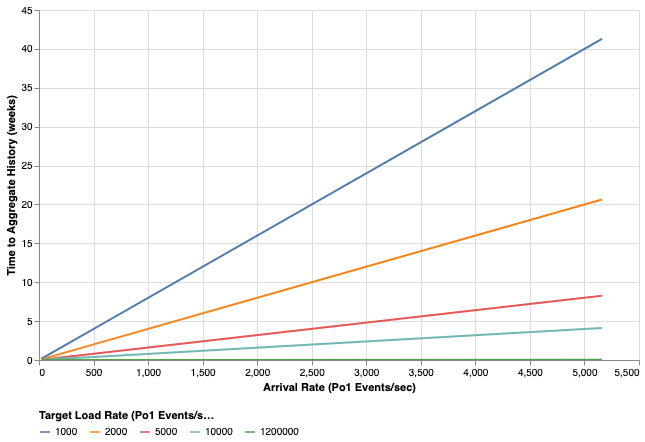

In [48]:
df = RPT.copy()
#domain = (0, y_height)
chart_one = alt.Chart(df).mark_line().encode(
    y=alt.Y('Time to Aggregate History (weeks)', scale=alt.Scale( type='linear', )),
    x=alt.X('Arrival Rate (Po1 Events/sec)', sort=['1 Year Total']),
    color=alt.Color('Target Load Rate (Po1 Events/sec):N', legend=alt.Legend(orient='bottom'))
).properties(width=600 , height=350)
chart_one

In [44]:
41 /4


10.25

In [303]:
.865 * 12

10.379999999999999

In [50]:
.03 * 7 * 24

5.04